# Clustering of Trajectories under Global Confounding -- Chen-Poor

In [1]:
import sys
# setting path
sys.path.append('../core')
import os
os.environ["VECLIB_MAXIMUM_THREADS"] = "10"


from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

import numba
from numba import jit, njit

import tqdm
from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

import dfply
from dfply import *
import ray
import datetime


import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy

import confound_mdp
import confound_ope
import confound_env
import copy

from subspace import *
from clustering import *
from emalg import *
from helpers import *

%matplotlib inline
plt.style.use('matplotlibrc')
import os
os.environ["VECLIB_MAXIMUM_THREADS"] = "10"

In [3]:
envs = []
# each row:
#   [mdp , pi_b, pi_e, horizon, gamma, nStates, nActions, term]


horizon = 100 #18
#, slip = 0.04, confound_weight=0.6
pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, 
                                                                    confound_weight=0.6, small=True, soft=True)
#R = -1*R
gridworld = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

nStates = P.shape[2]
nActions = P.shape[1]

pi_e = np.zeros((nStates, nActions))
for i in range(nStates):
    pi_e[i] = [0.4, 0.1, 0.4, 0.1]
    
envs.append([gridworld, pi_b, pi_e, horizon, gamma, nStates, nActions, -1, P, R, x_dist, u_dist, gamma])



In [5]:
for mdp , pi_b, pi_e, base_horizon, gamma, nStates, nActions, term, P, R, x_dist, u_dist, gamma in [envs[-1]]:
    
    print("---")
    
    print("running env with horizon", horizon)

    #dataset = confound_mdp.collect_sample(int(100), mdp, pi_b, horizon, iid=False)
    #pi_b = np.array([pi_b.mean(0),pi_b.mean(0)])
    dataset = getSamplesMultiProc(10000, mdp, pi_b, horizon, iid=False)
    data = dataset.reshape((dataset.shape[0]*dataset.shape[1],5))
    Phat = confound_ope.estimate_P(dataset, mdp)
    pihat = confound_ope.estimate_pi(dataset, mdp)
    for a in range(nActions):
        for s in range(nStates):
            if Phat[a,s].sum() == 0:
                Phat[a,s,term] = 1
            if pihat[s].sum() == 0:
                pihat[s,:] = 1/nActions
    pi_avg = pi_b[0] * u_dist[0] + pi_b[1] * u_dist[1]

    # This is the actual reward_sa
    # P(s,a,s') * R(s,a,s')
    # R(s,a) = \Sum_{s'} P(s,a,s') * R(s,a,s')
    R_sa = (np.average(P, axis=0, weights=u_dist) * R).sum(axis=2).T #np.sum(R, axis=2).T #.reshape(nStates, nActions)
    P_spsa = Phat.transpose((2, 1, 0))
    n = data.shape[0]


     # behavior value
    print("value of pi_b")
    returns = confound_mdp.calc_returns(dataset, gamma, horizon)
    print(returns.mean())

---
running env with horizon 100
value of pi_b
-1.603148649615563


In [6]:
from numba import njit
#Ptrue_spsa = np.einsum('u,uasp->psa', u_dist, P)
pi_bsa = np.einsum('u,usa->sa', u_dist, pi_b)
Pb_spsa = getPb_spsa(nStates, nActions, u_dist, pi_b, pi_bsa, P)

burnin = 10
N_sa = getN_sa(dataset, nStates, nActions, burnin=burnin)

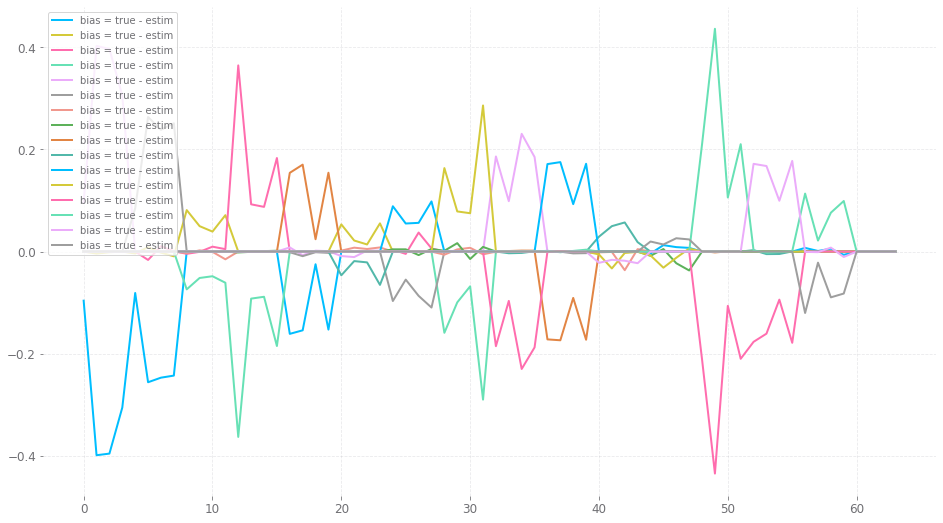

In [7]:
plt.figure(figsize=(16,9))
plt.plot((Pb_spsa - P_spsa).transpose(1,2,0).reshape(nStates*nActions, nStates), label='bias = true - estim')
plt.legend()

## Method 1: PCA >%> ToMATo Clustering >%> t-SNE

In [8]:
# x, a, u, x', r
dataset.shape

(10000, 100, 5)

In [9]:
stateactions = dataset[:, :, [0, 1]]
X = stateactions.reshape(stateactions.shape[0], stateactions.shape[1]*stateactions.shape[2])
fullX = dataset.reshape(dataset.shape[0], dataset.shape[1]*dataset.shape[2])

memorder = 'C'

#threes = dataset.reshape(int(dataset.shape[0] * dataset.shape[1] / 3), 3, dataset.shape[2])
concattrajs = dataset.reshape(dataset.shape[0]*dataset.shape[1], dataset.shape[2])
threes = np.array([concattrajs[i:i+3] for i in range(len(concattrajs)-2)])
print(threes.shape)
threes = dataset #comment for non-sanity check
print(threes.shape)
if memorder == 'F':
    stateactions = (threes[:,:,0] + threes[:,:,1]*nStates).astype(int) #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
else:
    stateactions = (threes[:,:,0]*nActions + threes[:,:,1]).astype(int)
states = (threes[:,:,0]).astype(int)
actions = (threes[:,:,1]).astype(int)
currstates = threes[:,:,[0,1]].astype(int)
confounders = threes[:,:,2].astype(int)
labels = confounders[:,0].astype(int)
nextstates = threes[:,:,3].astype(int)

L = 2
K = 2
#S = nStates*nActions
#N = len(threes)

(999998, 3, 5)
(10000, 100, 5)


## Mixing Time Analysis

So now we have our dataset encoded in something isomorphic to state-action tuples, we can take a look at mixing times. On a 4x4 gridworld, 15, 31, 47 and 63 correspond to the goal state under Fortran ordering. Under C ordering, it's 60, 61, 62, 63. Here's a plot of the distribution over state-action tuples over time.

In [19]:
np.array([np.bincount(states[:, 0].astype(int)[labels==i])/sum(labels==i) for i in range(max(labels+1))]).shape

(2, 16)

<AxesSubplot:>

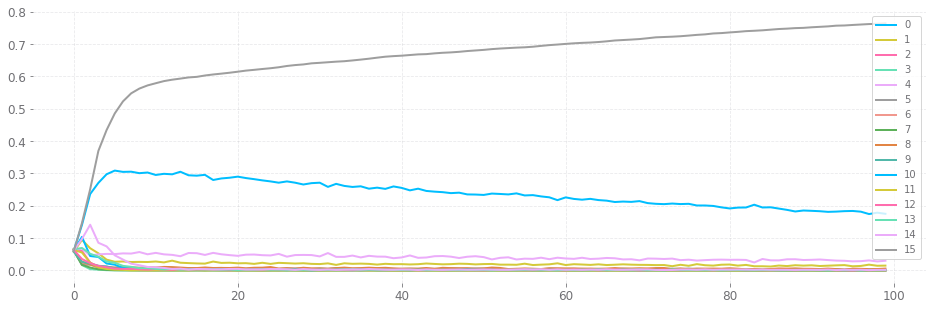

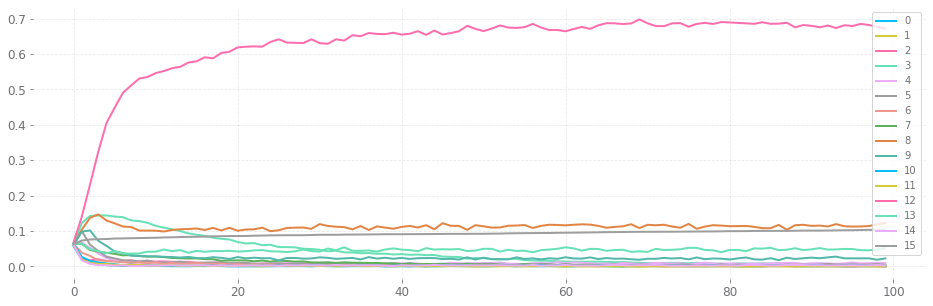

In [10]:
dist = np.array([np.bincount(states[:, i].astype(int)[labels==0], minlength=nStates) 
         for i in range(states.shape[1])])/sum(labels==0)
pd.DataFrame(dist).plot(figsize=(16,5))
dist = np.array([np.bincount(states[:, i].astype(int)[labels==1], minlength=nStates) 
         for i in range(states.shape[1])])/sum(labels==1)
pd.DataFrame(dist).plot(figsize=(16,5))

<AxesSubplot:>

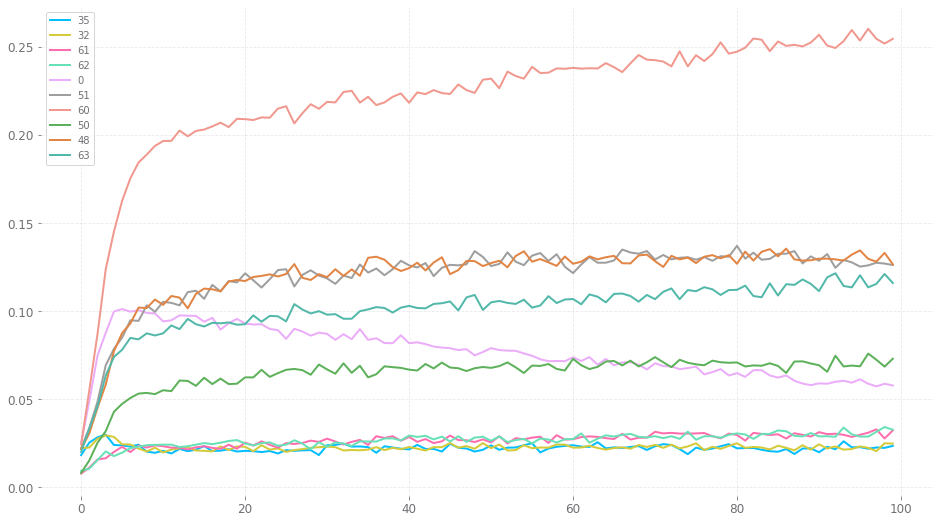

In [11]:
dist = np.array([np.bincount(stateactions[:, i].astype(int), minlength=nStates*nActions) 
         for i in range(stateactions.shape[1])])/len(labels)
pd.DataFrame(dist[:,np.argpartition(dist[-1,:], -10)[-10:]], 
            columns = np.argpartition(dist[-1,:], -10)[-10:]).plot(figsize=(16,9))
#pd.DataFrame(dist[:,[15,31,47,63]]/100000, 
#            columns = [15,31,47,63]).plot(figsize=(16,9))

And here's a plot of the L1-norm between distributions at step t and step t+1 over time. This converges really quickly to something in the neighborhood of 0.02. 

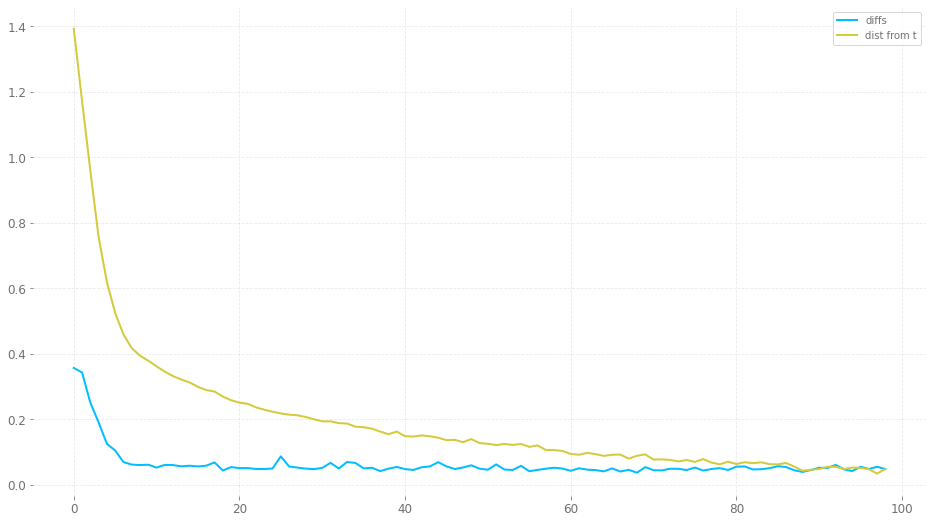

In [12]:
plt.figure(figsize=(16,9))
plt.plot(np.sum(np.abs(np.diff(dist, axis=0)),1), label='diffs')
plt.plot(np.sum(np.abs(dist - dist[-1])[:-1],1), label='dist from t')
plt.legend()

## Subspace Estimation

In [13]:
sadim = nStates*nActions
spdim = nStates
omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])
onehotsa = np.eye(int(np.max(stateactions))+1)[stateactions]
onehotsaflat = copy.deepcopy(onehotsa)
onehotsa = onehotsa.reshape((onehotsa.shape[0], onehotsa.shape[1], nStates, nActions), order=memorder)
onehotsp = np.eye(np.max(nextstates)+1)[nextstates]
sz = int(onehotsa.shape[0]/3)

In [14]:
onehotsasub = onehotsa[:sz]
onehotsaflatsub = onehotsaflat[:sz]
onehotspsub = onehotsp[:sz]

onehotsaclust = onehotsa[sz:2*sz]
onehotsaflatclust = onehotsaflat[sz:2*sz]
onehotspclust = onehotsp[sz:2*sz]

onehotsaclass = onehotsa[2*sz:]
onehotsaflatclass = onehotsaflat[2*sz:]
onehotspclass = onehotsp[2*sz:]

In [14]:
#np.array([i for i in range(64)]).reshape(nStates, nActions, order=memorder)
#so it turns out the s + a|S| ordering corresponds to Fortran ordering

In [15]:
eigvalsa, eigvecsa = getEig(onehotsasub, onehotspsub, omegaone, omegatwo, K, wt=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [16]:
eigvalsp, eigvecsp = getEigKs(onehotsasub, onehotspsub, omegaone, omegatwo, K)

Finally, as a sanity check, we plot the absolute difference in eigenvalues on the log scale. We want this to always be nonzero, so if any entry is missing in the plot, then we'd be in trouble.

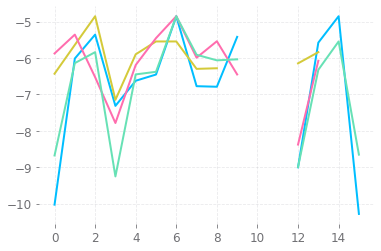

In [17]:
plt.plot(np.log(np.abs(eigvalsa[:,:,0] - eigvalsa[:,:,1])))

In [18]:
vals, vecs = getEig(onehotsasub, onehotspsub, omegaone, omegatwo, 10000, wt=True)

(array([12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-46.05170186, -45.42602811, -44.80035437, -44.17468062,
        -43.54900687, -42.92333313, -42.29765938, -41.67198563,
        -41.04631189, -40.42063814, -39.79496439, -39.16929065,
        -38.5436169 , -37.91794315, -37.29226941, -36.66659566,
        -36.04092191, -35.41524817, -34.78957442, -34.16390067,
        -33.53822692, -32.91255318, -32.28687943, -31.66120568,
        -31.03553194, -30.40985819, -29.78418444, -29.1585107 ,
        -28.53283695, -27.9071632 , -27.28148946, -26.65581571,
        -26.03014196, -25.40446822, -24.77879447, -24.15312072,
        -23.52744698, -22.90177323, -22.27609948, -21.65042574

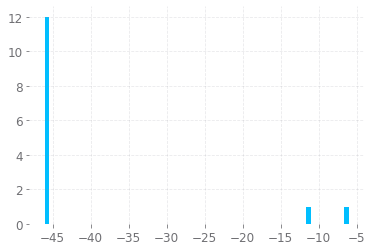

In [19]:
plt.hist(np.log(vals[1,0]+1e-20), bins=64) #(s,a,eigs)

In [20]:
eigvecsa.shape #(s,a,sp,k)

(16, 4, 16, 2)

## Clustering

In [18]:
omegaone

array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
#omegaone = np.arange(omegaone[0], omegatwo[-1])
#omegatwo = omegaone

In [ ]:
#omgone = np.arange(omegaone[0], omegatwo[-1])[:int(len(np.arange(omegaone[0], omegatwo[-1]))/2)]
#omgtwo = np.arange(omegaone[0], omegatwo[-1])[int(len(np.arange(omegaone[0], omegatwo[-1]))/2):]
#omegaone = omgone
#omegatwo = omgtwo

In [21]:
G = 3
omgones = np.array_split(omegaone,G)
omgtwos = np.array_split(omegatwo,G)
minlen = min([len(i) for i in omgones + omgtwos])
omgones = np.array([i[:minlen] for i in omgones])
omgtwos = np.array([i[:minlen] for i in omgtwos])

In [22]:
hs = geths(onehotsaclust, onehotspclust, omgones, omgtwos, G)
hs = hs[[g for g in range(G) if g % 2 == 0]].mean(0)

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.50it/s]


In [23]:
device = "/GPU:0"

#statmns = computeStat(geth(onehotsaclust[:,omegaone,:,:], onehotspclust[:,omegaone,:]), 
#                      geth(onehotsaclust[:,omegatwo,:,:], onehotspclust[:,omegatwo,:]), 
#                      eigvecsa, device=device)
statmns = computeStat(np.array([geth(onehotsaclust[:,omegaone,:,:], onehotspclust[:,omegaone,:]), 
                      geth(onehotsaclust[:,omegatwo,:,:], onehotspclust[:,omegatwo,:])]), eigvecsa, device=device, proj=True)
statmns2 = computeStat(hs, eigvecsa, device=device, proj=True)

Metal device set to: Apple M1 Max


<AxesSubplot:ylabel='Density'>

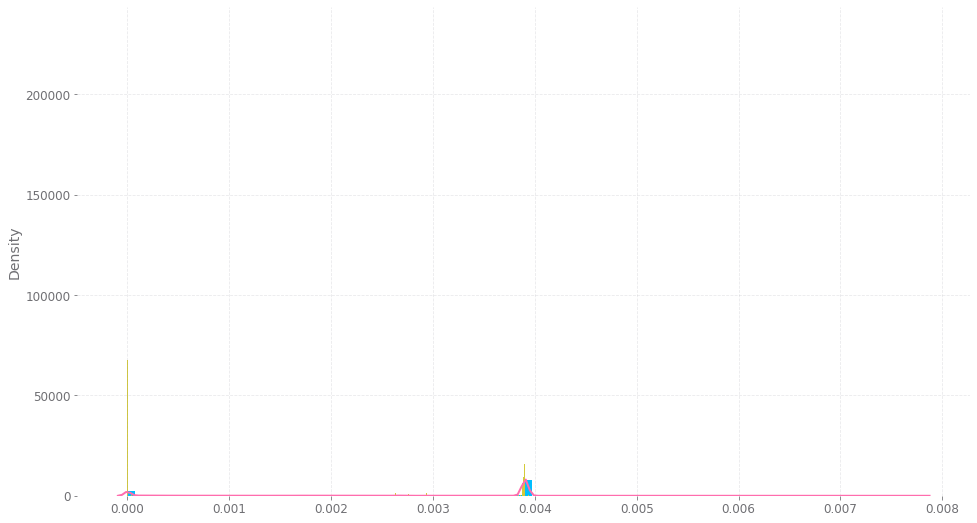

In [24]:
import seaborn as sns
plt.figure(figsize=(16,9))
plt.hist(statmns.flatten(), bins=100, density=True)[2]
plt.hist(statmns.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
sns.kdeplot(statmns.flatten(), bw_adjust=0.5)

<AxesSubplot:ylabel='Density'>

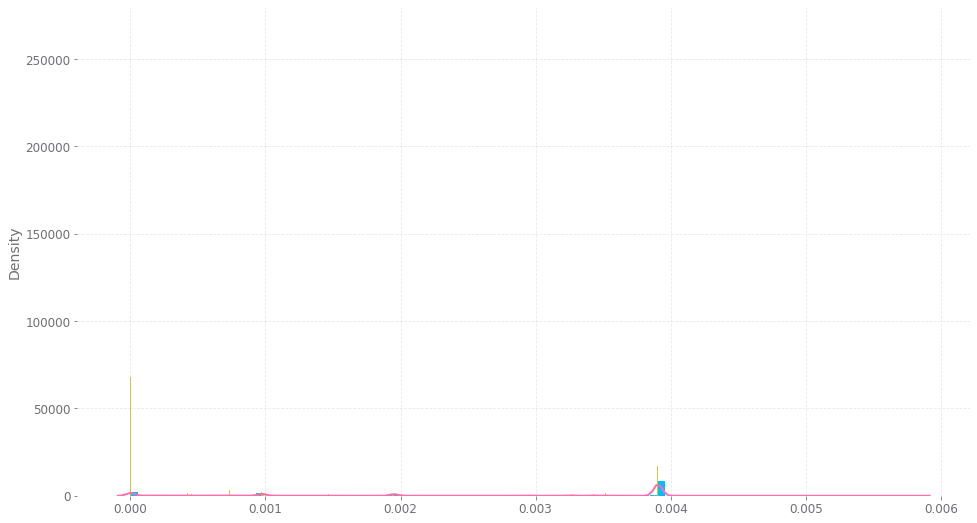

In [25]:
import seaborn as sns
plt.figure(figsize=(16,9))
plt.hist(statmns2.flatten(), bins=100, density=True)[2]
plt.hist(statmns2.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
sns.kdeplot(statmns2.flatten(), bw_adjust=0.5)

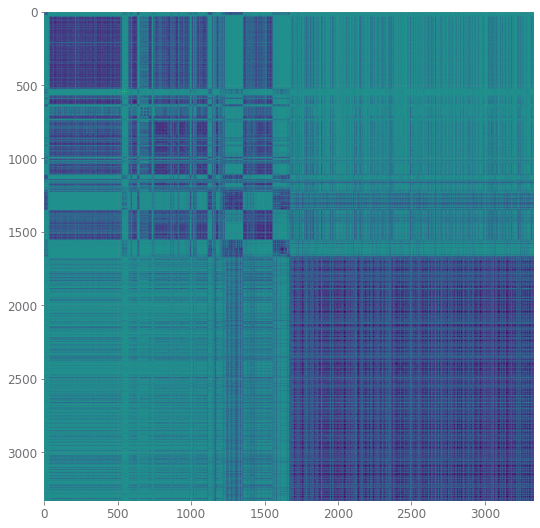

In [26]:
from scipy.cluster.hierarchy import linkage

m = 1-statmns #need similarity matrix
# shuffle
perm = np.random.permutation(len(m))
m = m[perm][:, perm]

# reorder
y = m[np.triu_indices(len(m), k=1)]
Z = linkage(y, method='single', optimal_ordering=True)
perm = np.ravel(Z[:, :2]).astype(np.int32)
perm = perm[perm < len(m)]
m = m[perm][:, perm]

plt.figure(figsize=(16,9))
plt.imshow(1-m)

100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.26it/s]


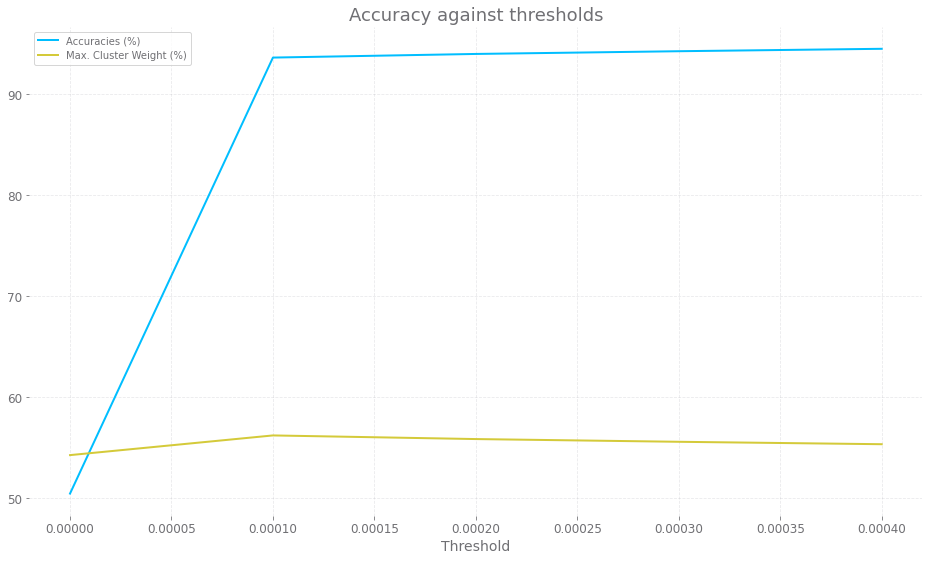

In [27]:
clusterDiagnostics(statmns, K=K, labels=confounders[sz:2*sz, 0],
                   lo=0, hi=0.0005, step=0.0001) #0,0.01, 0.0001

100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.50it/s]


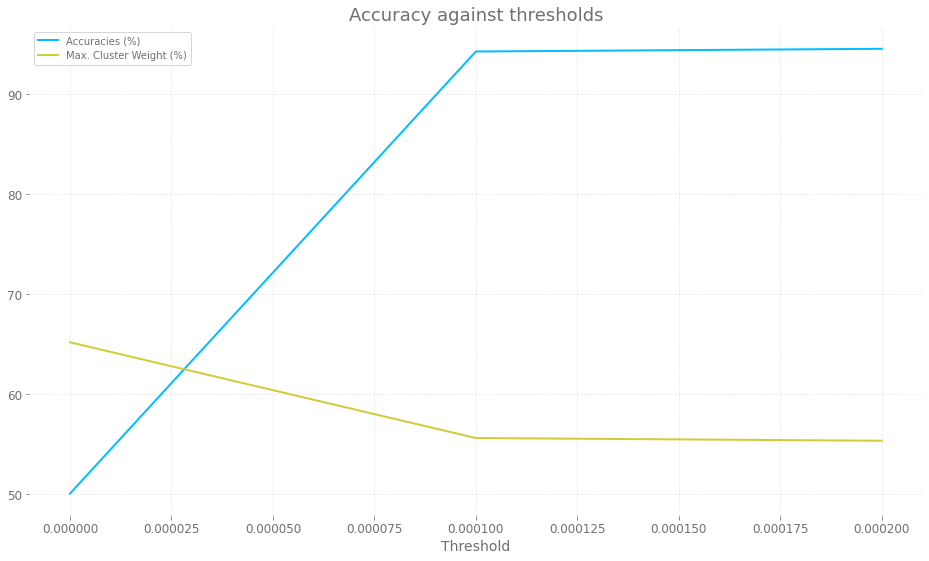

In [28]:
clusterDiagnostics(statmns2, K=K, labels=confounders[sz:2*sz, 0],
                   lo=0, hi=0.00025, step=0.0001)

In [29]:
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=5.0, metric='precomputed').fit_transform(statmns) #1-(statmns2 < 0.002)

Text(0.5, 0.98, 't-SNE Visualizations of Clusters and Confounders, Thresholded Distances')

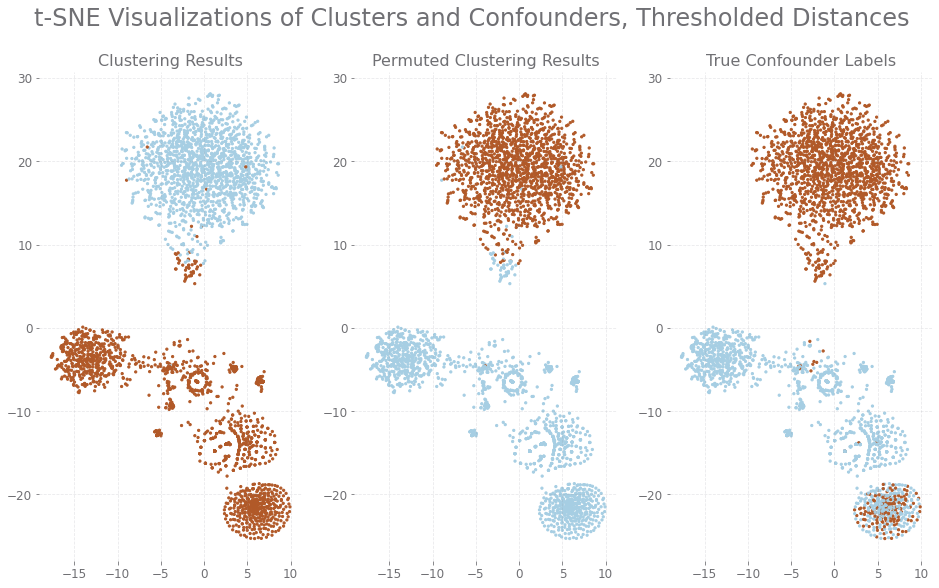

In [30]:
clusterlabs = sklearn.cluster.spectral_clustering((statmns < 0.0001).astype(int), n_clusters=K,
                                                     assign_labels='kmeans')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsne[:,0], tsne[:,1], c=clusterlabs, cmap='Paired', s=5)
axes[1].scatter(tsne[:,0], tsne[:,1], c=1-clusterlabs, cmap='Paired', s=5)
axes[2].scatter(tsne[:,0], tsne[:,1], c=labels[sz:2*sz], cmap='Paired', s=5)
axes[0].set_title('Clustering Results', fontsize=16)
axes[1].set_title('Permuted Clustering Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Clusters and Confounders, Thresholded Distances', fontsize=24)

In [31]:
permutation = np.argmax([np.mean(clusterlabs == confounders[sz:2*sz, 0]), 
                    np.mean(clusterlabs != confounders[sz:2*sz, 0])])
print(permutation, np.max([np.mean(clusterlabs == confounders[sz:2*sz, 0]), 
                    np.mean(clusterlabs != confounders[sz:2*sz, 0])]))

1 0.9363936393639364


(array([1460.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1873.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

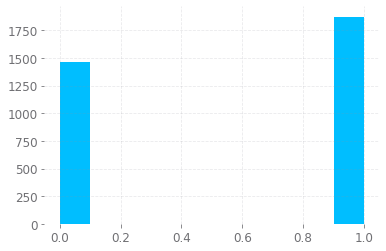

In [38]:
plt.hist(clusterlabs)

## Model Estimation

In [32]:
Phat_ksa = getModelEstim(clusterlabs.astype(int), 
                         states[sz:2*sz,:], 
                         actions[sz:2*sz,:], 
                         nextstates[sz:2*sz,:],
                        K=K, nStates=nStates, nActions=nActions, hard=True)

## Classification

In [123]:
np.bincount(clusterlabs)/len(clusterlabs) 

array([0.50945095, 0.49054905])

In [153]:
%load_ext autoreload
%autoreload 2
from emalg import *
from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
import numpy as np
from numba import jit, njit, prange
import multiprocessing
from itertools import repeat
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import copy
import helpers


# Gets starting state probabilities per confounder
def getStartWeights(states, predlabs, K, nStates, hard=True):
    wts = np.zeros((K, nStates))
    if hard:
        for i in range(len(states)):
            wts[predlabs[i],states[i, 0]] += 1
        return wts/np.array([sum(predlabs==k) for k in range(K)])[:,None]
    else:
        for i in range(len(states)):
            for k in range(K):
                wts[k,states[i, 0]] += predlabs[k, i]
        return wts/np.sum(wts, axis=1)[:,None]

@njit(parallel=False, cache=True)
def getPolicyHelperSoft(states, actions, K, nStates, nActions, predprobs):
    pi_ksa = np.zeros((K, nStates, nActions)) #k, s, a
    for i in range(states.shape[0]):
        for j in range(states.shape[1]):
            for k in range(K):
                pi_ksa[int(k), 
                       int(states[i,j]), 
                       int(actions[i,j])] += predprobs[k, i]
    return pi_ksa

@njit(parallel=False, cache=True)
def getPolicyHelperLabs(states, actions, K, nStates, nActions, predlabs):
    pi_ksa = np.zeros((K, nStates, nActions)) #k, s, a
    for i in range(states.shape[0]):
        for j in range(states.shape[1]):
            pi_ksa[int(predlabs[i]), 
                   int(states[i,j]), 
                   int(actions[i,j])] += 1
    return pi_ksa

@njit(parallel=False, cache=True)
def getPolicyHelper(states, actions, nStates, nActions):
    pi_sa = np.zeros((nStates, nActions)) #s,a
    for i in range(states.shape[0]):
        for j in range(states.shape[1]):
            pi_sa[int(states[i,j]), int(actions[i,j])] += 1
    return pi_sa

def getPolicyEstim(states, actions, K, nStates, nActions, preds=None, hard=True):
    if not hard:
        pi = getPolicyHelperSoft(states, actions, K, nStates, nActions, preds)
    elif preds is not None:
        pi = getPolicyHelperLabs(states, actions, K, nStates, nActions, preds)
    else:
        pi = getPolicyHelper(states, actions, nStates, nActions)
    return pi/np.nansum(pi, axis=-1)[...,None]

@njit(parallel=False, cache=True)
def getmodelestim(clusterlabs, states, actions, nextstates,
                  K, nStates, nActions):
    Phat_ksa = np.zeros((K, nStates, nActions, nStates))
    for i in prange(states.shape[0]):
        for j in range(states.shape[1]):
            Phat_ksa[int(clusterlabs[i]), 
                     int(states[i,j]), 
                     int(actions[i,j]), 
                     int(nextstates[i,j])] += 1
    return Phat_ksa

@njit(parallel=False, cache=True)
def getmodelestimsoft(expect, states, actions, nextstates,
                  K, nStates, nActions):
    Phat_ksa = np.zeros((K, nStates, nActions, nStates))
    for i in prange(states.shape[0]):
        for j in range(states.shape[1]):
            for k in range(K):
                Phat_ksa[k, 
                         int(states[i,j]), 
                         int(actions[i,j]), 
                         int(nextstates[i,j])] += expect[k,i]
    return Phat_ksa

def getModelEstim(clusterlabs, states, actions, nextstates,
                  K, nStates, nActions, hard=True):
    if hard:
        model = getmodelestim(clusterlabs, states, actions, nextstates,
                  K, nStates, nActions)
    else:
        model = getmodelestimsoft(clusterlabs, states, actions, nextstates,
                  K, nStates, nActions)
    return model / np.nansum(model, axis=-1)[..., None]


def getloglik(expect, modelestim, states, actions, nextstates, hard=True):
    if hard:
        return np.nansum(
                    np.nansum(
                        np.log(modelestim[:, states, actions, nextstates]), 
                    axis=-1)[expect, np.arange(len(states))])
    else:
        return np.nansum(
                    np.nansum(
                        np.log(np.nansum(modelestim[:, states, actions, nextstates] 
                                        * expect[...,None], axis=0)),
                    axis=-1))

def classify(model, states, actions, nextstates, policy=None, reg=0, prior=None, startweights=None, labs=True):
    if policy is not None:
        probs = np.nansum(np.log(model[:, states, actions, nextstates])
                    + np.log(policy[:, states, actions]), axis=-1)
    else:
        probs = np.nansum(np.log(model[:, states, actions, nextstates]), axis=-1)
    if startweights is not None:
        probs += np.log(startweights[:,states[:,0]])
    
    probs += np.random.uniform(high=1e-7, size=probs.shape)
    if reg > 0:
        probs += reg*np.log(prior)[:,None]
    if labs:
        return probs.argmax(0)
    else:
        return probs
    
def em(expect, modelestim, states, actions, nextstates, labels, 
                K, nStates, nActions, prior, 
               max_iter = 100, min_iter = 10, checkin=5, reg = 0,
               permute=False, permutation=0, verbose=True, hard=True):
    i = 0
    modelold = np.ones(modelestim.shape)
    while i < min_iter or np.nansum(np.abs(modelold - modelestim)) > 1e-3:
        modelold = modelestim
        
        if hard:
            policy = getPolicyEstim(states, actions, 
                         K, nStates, nActions, expect, hard=True)
            modelestim = getModelEstim(expect.astype(int), states, actions, nextstates,
                                       K=K, nStates=nStates, nActions=nActions, hard=True)
            startweights = getStartWeights(states, expect, K, nStates, hard=True)
            expectprobs = np.nansum(np.log(modelestim[:, states, actions, nextstates])
                                    + np.log(policy[:, states, actions]), -1) + np.log(startweights[:,states[:,0]])
            expectprobs += np.random.uniform(high=1e-7, size=expectprobs.shape)
            expect = (expectprobs + #random number to perturb argmax 
                      reg*np.log(prior)[:,None]).argmax(0)
            prior = np.bincount(expect)/len(expect)
        else:
            policy = getPolicyEstim(states, actions, 
                         K, nStates, nActions, expect, hard=False)
            modelestim = getModelEstim(expect, states, actions, nextstates,
                                       K=K, nStates=nStates, nActions=nActions, hard=False)
            startweights = getStartWeights(states, expect, K, nStates, hard=False)
            expectprobs = (np.nansum(np.log(modelestim[:, states, actions, nextstates]) 
                                    + np.log(policy[:, states, actions]), axis=-1) 
                           + np.log(startweights[:,states[:,0]]))
            expectprobs += np.random.uniform(high=1e-7, size=expectprobs.shape)
            expect = np.exp(expectprobs + 
                            reg*np.log(prior)[:,None])
            expect = (expect / np.nansum(np.abs(expect), axis=0))
            prior = np.bincount(expect.argmax(0))/len(expect) #fix to soft prior
        
        i += 1
        if i % checkin == 0 and verbose:
            print('iteration', i, 'diff', np.nansum(np.abs(modelold - modelestim)))
            expectlabs = expect if hard else expect.argmax(0)
            if permute:
                print('accuracy:', max(np.mean(expectlabs == labels), np.mean(expectlabs != labels)))
                    
            else:
                print('accuracy:', [np.mean(expectlabs == labels), np.mean(expectlabs != labels)][permutation])
            print(getloglik(expect, modelestim, states, actions, nextstates, hard=hard))
        if i > max_iter:
            break
    loglik = getloglik(expect, modelestim, states, actions, nextstates, hard=hard)
    if verbose:
        print('log-likelihood:', loglik)
    return expect, modelestim, loglik

In [102]:
startweights.shape

(2, 16)

In [81]:
np.log(startweights[:,states[:,0]]).shape

(2, 10000)

In [138]:
#denoised model estimate
Phat_ksad = np.array([eigvecsa @ eigvecsa.transpose(0,1,3,2) @ Phat_ksa[k,:,:,:,None] for k in range(K)]).squeeze()
#projected models
projPhat = np.array([eigvecsa.transpose(0,1,3,2) @ Phat_ksa[k,:,:,:,None] for k in range(K)]).squeeze()


priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
piclust = getPolicyEstim(states[sz:2*sz], actions[sz:2*sz], 
                         K, nStates, nActions, preds=clusterlabs, hard=True)

startweights = getStartWeights(states[sz:2*sz], clusterlabs, K, nStates)
maxapos = classify(Phat_ksa, states[2*sz:,:], actions[2*sz:,:], 
                       nextstates[2*sz:,:], piclust, reg=1, 
                   prior=priorclass, startweights = startweights, labs=True)
mle = classify(Phat_ksa, states[2*sz:,:], actions[2*sz:,:], 
                       nextstates[2*sz:,:], piclust, reg=0, 
               prior=None, startweights = startweights, labs=True)
mleprobs = classify(Phat_ksa, states[2*sz:,:], actions[2*sz:,:], 
                       nextstates[2*sz:,:], piclust, reg=0, 
                    prior=None, startweights = startweights, labs=False)

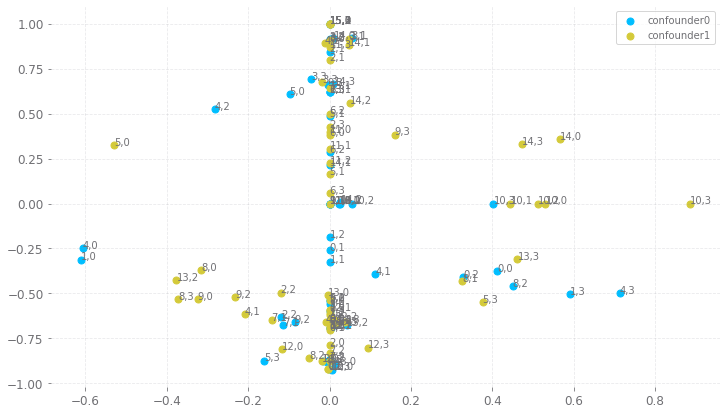

In [139]:
plt.figure(figsize=(12,7))
plt.scatter(projPhat.reshape(K, nStates*nActions, K)[0,:,0], projPhat.reshape(K, nStates*nActions, K)[0,:,1], label='confounder0')
plt.scatter(projPhat.reshape(K, nStates*nActions, K)[1,:,0], projPhat.reshape(K, nStates*nActions, K)[1,:,1], label='confounder1')
for s in range(nStates):
    for a in range(nActions):
        for k in range(K):
            plt.text(projPhat[k,s,a,0], projPhat[k,s,a,1], s=(str(s)+','+str(a)))
plt.legend()

In [140]:
np.mean(labels[2*sz:] == maxapos)
print('MAP estimate accuracy:', [np.mean(labels[2*sz:] == maxapos), np.mean(labels[2*sz:] != maxapos)][permutation])
print('MLE accuracy:', [np.mean(labels[2*sz:] == mle), np.mean(labels[2*sz:] != mle)][permutation])

MAP estimate accuracy: 0.9553089382123575
MLE accuracy: 0.9553089382123575


In [282]:
%load_ext autoreload
%autoreload 2
from subspace import *
from clustering import *
from emalg import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
expectclass, modelestimclass, loglikclass = em(maxapos, 
                            Phat_ksa, states[2*sz:], actions[2*sz:], 
                        nextstates[2*sz:], labels=labels[2*sz:], 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 1, max_iter=100,
                                               permute=True, permutation=permutation,
                                               checkin=1, hard=True)

iteration 1 diff 18.230840759180797
accuracy: 0.9553089382123575
-114808.83240840121
iteration 2 diff 0.0
accuracy: 0.9553089382123575
-114808.83240840121
log-likelihood: -114808.83240840121


In [142]:
expectclasssoft, modelestimclasssoft, loglikclasssoft = em((np.exp(mleprobs)/np.nansum(np.exp(mleprobs), 0)), 
                            Phat_ksa, states[2*sz:], actions[2*sz:], 
                        nextstates[2*sz:], labels[2*sz:], 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, hard=False)

iteration 1 diff 18.227682927891088
accuracy: 0.9553089382123575
-114808.8324862182
iteration 2 diff 0.003698807283129526
accuracy: 0.9553089382123575
-114808.83240840121
iteration 3 diff 1.9029916534766724e-15
accuracy: 0.9553089382123575
-114808.83240840121
log-likelihood: -114808.83240840121


In [259]:
np.exp(mleprobs)/np.exp(mleprobs).sum(0)

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.4470391e-19, 1.0000000e+00, 1.0000000e+00, ..., 1.0000000e+00,
        1.0000000e+00, 1.0000000e+00]])

## Refinement

In [208]:
%load_ext autoreload
%autoreload 2
from emalg import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
catlabelsmap = np.concatenate([clusterlabs, maxapos]).astype(int)
catlabelsmle = np.concatenate([clusterlabs, mle]).astype(int)
catlabelsem = np.concatenate([clusterlabs, expectclass]).astype(int)
refinemap = getModelEstim(catlabelsmap, 
                       states[sz:,:], actions[sz:,:], nextstates[sz:,:],
                          K=K, nStates=nStates, nActions=nActions, hard=True)
refinemle = getModelEstim(catlabelsmle, 
                       states[sz:,:], actions[sz:,:], nextstates[sz:,:],
                          K=K, nStates=nStates, nActions=nActions, hard=True)
refineem = getModelEstim(catlabelsem, 
                       states[sz:,:], actions[sz:,:], nextstates[sz:,:],
                          K=K, nStates=nStates, nActions=nActions, hard=True)

In [144]:
refinemlelab = classify(refinemle, states[sz:,:], actions[sz:,:],
                        nextstates[sz:,:], reg=0, prior=None, labs=True)
refinemaplab = classify(refinemap, states[sz:,:], 
                        actions[sz:,:],
                        nextstates[sz:,:], 
                        reg=1, 
                        prior=np.bincount(catlabelsmap)/len(catlabelsmap), 
                        labs=True)
refineemlab = classify(refineem, states[sz:,:], actions[sz:,:],
                        nextstates[sz:,:], reg=0, prior=None, labs=True)
refinemleprobs = classify(refinemle, states[sz:,:], actions[sz:,:],
                        nextstates[sz:,:], reg=0, prior=None, labs=False)

In [146]:
print('MAP estimate accuracy:', [np.mean(refinemaplab == labels[sz:]), np.mean(refinemaplab != labels[sz:])][permutation])
print('MLE accuracy:', [np.mean(refinemlelab == labels[sz:]), np.mean(refinemlelab != labels[sz:])][permutation])

MAP estimate accuracy: 0.9511024448777561
MLE accuracy: 0.9523023848807559


In [149]:
print('Hard EM Algorithm') 
expect, modelestim, loglikrefine = em(refineemlab, refineem, states[sz:,:], 
                                      actions[sz:,:], nextstates[sz:,:], labels[sz:], 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 1, permute=True, permutation=permutation, checkin=1, hard=True)

Hard EM Algorithm
iteration 1 diff 8.402861579528288
accuracy: 0.9877006149692515
-229957.63451658637
iteration 2 diff 0.9034288590259931
accuracy: 0.9877006149692515
-229942.18731717038
iteration 3 diff 0.0
accuracy: 0.9877006149692515
-229942.18731717038
log-likelihood: -229942.18731717038


In [205]:
print('Soft EM Algorithm')
expect, modelestim, loglikrefine = em(np.exp(refinemleprobs)/np.nansum(np.exp(refinemleprobs),0), 
                                          refineem, states[sz:,:], 
                                      actions[sz:,:], nextstates[sz:,:], labels[sz:], 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 1, permute=True, permutation=permutation, checkin=1, hard=False)

Soft EM Algorithm
iteration 1 diff 9.189267257324968
accuracy: 0.9877006149692515
-229958.2375140833
iteration 2 diff 1.6651077561773264
accuracy: 0.9877006149692515
-229942.3315953264
iteration 3 diff 0.036361575550572754
accuracy: 0.9877006149692515
-229942.1873171706
iteration 4 diff 1.6341095143701523e-15
accuracy: 0.9877006149692515
-229942.1873171706
iteration 5 diff 1.4296090619348588e-64
accuracy: 0.9877006149692515
-229942.1873171706
iteration 6 diff 2.0647181781304296e-84
accuracy: 0.9877006149692515
-229942.1873171706
iteration 7 diff 2.9819766909359234e-104
accuracy: 0.9877006149692515
-229942.1873171706
iteration 8 diff 4.306730838830064e-124
accuracy: 0.9877006149692515
-229942.1873171706
iteration 9 diff 6.220011792260387e-144
accuracy: 0.9877006149692515
-229942.1873171706
iteration 10 diff 8.983274859152158e-164
accuracy: 0.9877006149692515
-229942.1873171706
log-likelihood: -229942.1873171706


## Stable Baselines: EM Algorithm Alone

In [224]:
randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
randmodel = getModelEstim(randlabs[sz:], states[sz:], actions[sz:], nextstates[sz:], 
                          K, nStates, nActions, hard=True)
randlabs, randmodel, loglikrand = em(randlabs[sz:], randmodel,
   states[sz:], actions[sz:], nextstates[sz:], labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, hard=True)

iteration 1 diff 0.0
accuracy: 1.0
-240589.4035479973
iteration 2 diff 12.516340967813285
accuracy: 1.0
-239044.01630179037
iteration 3 diff 14.422176922166665
accuracy: 1.0
-236976.18283325495
iteration 4 diff 17.464127553586124
accuracy: 1.0
-235919.0128224433
iteration 5 diff 4.669931009797219
accuracy: 1.0
-235884.12702197232
iteration 6 diff 1.5011342598797537
accuracy: 1.0
-235916.74196987238
iteration 7 diff 0.5240868263917599
accuracy: 1.0
-235915.6380430048
iteration 8 diff 0.0
accuracy: 1.0
-235915.6380430048
iteration 9 diff 0.0
accuracy: 1.0
-235915.6380430048
iteration 10 diff 0.0
accuracy: 1.0
-235915.6380430048
log-likelihood: -235915.6380430048


In [220]:
randmodelsoft.shape

(2, 16, 4, 16)

In [221]:
unifs = np.random.uniform(size=len(dataset))
randlabsoft = np.vstack([unifs, 1-unifs])
randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                              K, nStates, nActions, hard=False)
randlabsoft, randmodelsoft, loglikrandsoft = em(randlabsoft, randmodelsoft,
   states[sz:], actions[sz:], nextstates[sz:], labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, hard=False)

iteration 1 diff 3.3884038284401066
accuracy: 1.0
-241006.01194721082
iteration 2 diff 1.4074294050630685
accuracy: 1.0
-240784.05680542547
iteration 3 diff 8.878088034828446
accuracy: 1.0
-237809.7890021665
iteration 4 diff 28.788160595578077
accuracy: 1.0
-232065.9322778104
iteration 5 diff 22.503126787143472
accuracy: 1.0
-229566.71842932713
iteration 6 diff 2.2488316306224685
accuracy: 1.0
-229459.01577592496
iteration 7 diff 6.938893903907238e-18
accuracy: 1.0
-229459.01577592496
iteration 8 diff 2.7346802170080665e-63
accuracy: 1.0
-229459.01577592496
iteration 9 diff 3.025727783636166e-92
accuracy: 1.0
-229459.01577592496
iteration 10 diff 5.06053900801026e-121
accuracy: 1.0
-229459.01577592496
log-likelihood: -229459.01577592496


In [ ]:
randlabsoft.argmax(0) != labels

In [211]:
labelsemsoft = []
logliksemsoft = []
for i in tqdm(range(30)):
    unifs = np.random.uniform(size=len(dataset))
    randlabsoft = np.vstack([unifs, 1-unifs])
    randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                              K, nStates, nActions, hard=False)
    randlabsoft, randmodelsoft, loglikrand = em(randlabsoft, randmodelsoft,
   states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=False)
    labelsemsoft.append(randlabsoft)
    logliksemsoft.append(loglikrand)

100%|███████████████████████████████████████████| 30/30 [00:29<00:00,  1.00it/s]


In [212]:
labelsem = []
logliksem = []
for i in tqdm(range(30)):
    randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
    randmodel = getModelEstim(randlabs, states, actions, nextstates,
                              K, nStates, nActions, hard=True)
    randlabs, randmodel, loglikrand = em(randlabs, randmodel,
       states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=True)
    labelsem.append(randlabs)
    logliksem.append(loglikrand)

100%|███████████████████████████████████████████| 30/30 [00:32<00:00,  1.08s/it]


Text(0.5, 1.0, 'Randomly Initialized Hard EM Algorithm')

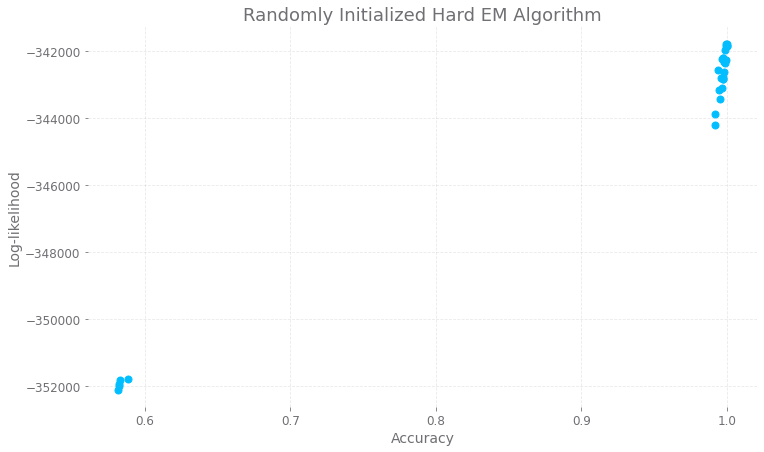

In [222]:
plt.figure(figsize=(12,7))
plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem], logliksem)
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Hard EM Algorithm')

Text(0.5, 1.0, 'Randomly Initialized Soft EM Algorithm')

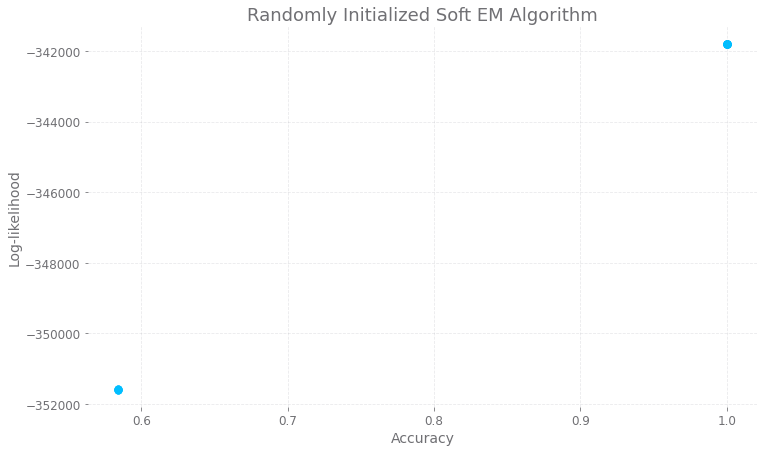

In [223]:
plt.figure(figsize=(12,7))
plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
            logliksemsoft)
plt.ticklabel_format(style='plain',useOffset=False)
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Soft EM Algorithm')

(array([ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

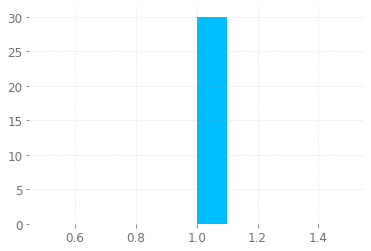

In [141]:
plt.hist([max(np.mean(i == labels[sz:]), np.mean(i != labels[sz:])) for i in np.array(labelsemsoft).argmax(axis=1)])

(array([17.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 13.]),
 array([0.69266537, 0.71847908, 0.74429279, 0.77010649, 0.7959202 ,
        0.82173391, 0.84754762, 0.87336133, 0.89917504, 0.92498875,
        0.95080246]),
 <BarContainer object of 10 artists>)

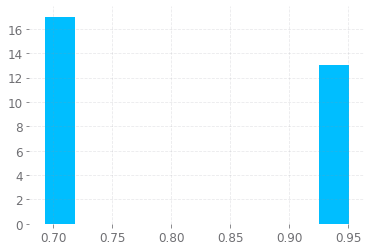

In [95]:
plt.hist([max(np.mean(i == labels[sz:]), np.mean(i != labels[sz:])) for i in labelsem])

## Stable Baselines: Occupancy Counts Past Mixing Time

In [160]:
onehots = onehotsaclust[:, omegatwo,...].sum(1)
statbase = np.abs(onehots[None,...] - onehots[:,None,...]).sum(axis=(2,3))
tsnebase = sklearn.manifold.TSNE(n_components=2, perplexity=5.0, 
                                 metric='precomputed').fit_transform(statbase)
clusterlabs = sklearn.cluster.spectral_clustering((statbase.max() - statbase), n_clusters=K,
                                                     assign_labels='kmeans')
max(np.mean(clusterlabs == labels[sz:2*sz]), np.mean(clusterlabs != labels[sz:2*sz]))

0.9882988298829883

In [162]:
transitions = geth(onehotsa, onehotsp, simple=False)

In [ ]:
statnaive = np.abs(transitions[None,...] - transitions[:,None,...]).sum(axis=(2,3,4))

Text(0.5, 0.98, 't-SNE Visualizations of Clusters and Confounders, Thresholded Distances')

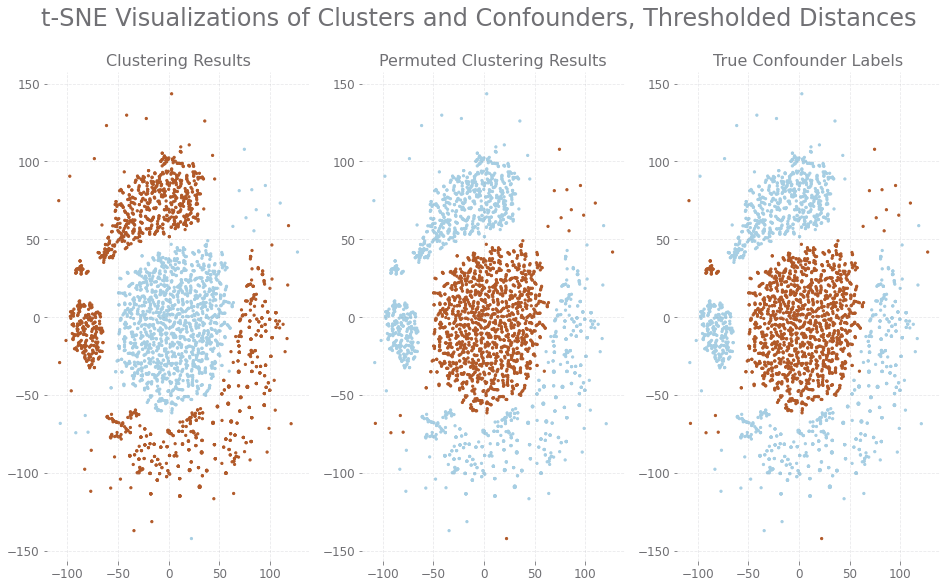

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsnebase[:,0], tsnebase[:,1], c=clusterlabs, cmap='Paired', s=5)
axes[1].scatter(tsnebase[:,0], tsnebase[:,1], c=1-clusterlabs, cmap='Paired', s=5)
axes[2].scatter(tsnebase[:,0], tsnebase[:,1], c=labels[sz:2*sz], cmap='Paired', s=5)
axes[0].set_title('Clustering Results', fontsize=16)
axes[1].set_title('Permuted Clustering Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Clusters and Confounders, Thresholded Distances', fontsize=24)

## MLE vs MAP

Text(0.5, 0.98, 't-SNE Visualizations of Post-Refinement MLE and Confounders, Thresholded Distances')

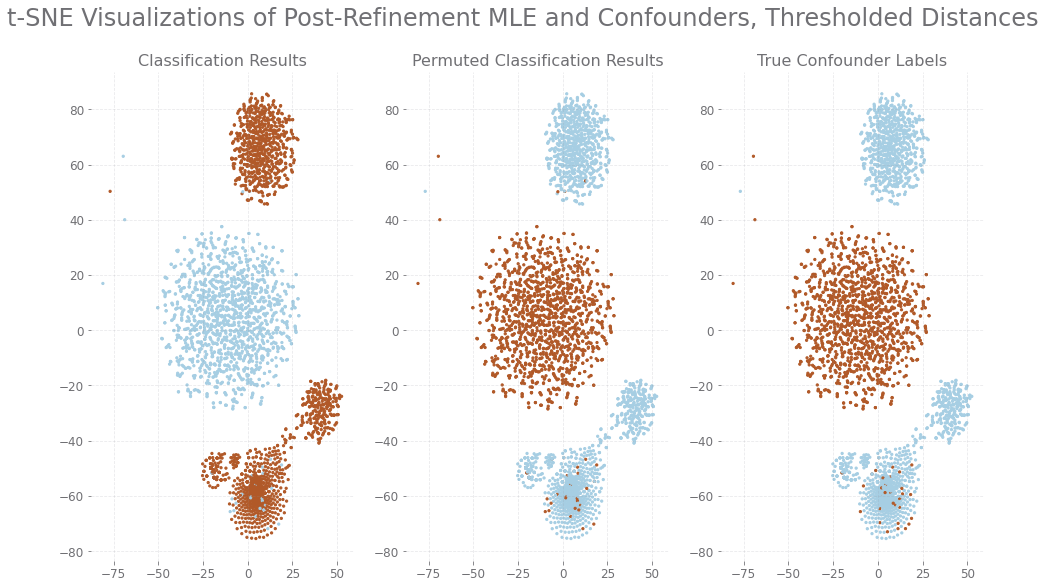

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsne[:,0], tsne[:,1], c=refinemlelab[:sz], cmap='Paired', s=5)
axes[1].scatter(tsne[:,0], tsne[:,1], c=1-refinemlelab[:sz], cmap='Paired', s=5)
axes[2].scatter(tsne[:,0], tsne[:,1], c=labels[sz:2*sz], cmap='Paired', s=5)
axes[0].set_title('Classification Results', fontsize=16)
axes[1].set_title('Permuted Classification Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Post-Refinement MLE and Confounders, Thresholded Distances', fontsize=24)

Text(0.5, 0.98, 't-SNE Visualizations of Post-Refinement MAP Labels and Confounders, Thresholded Distances')

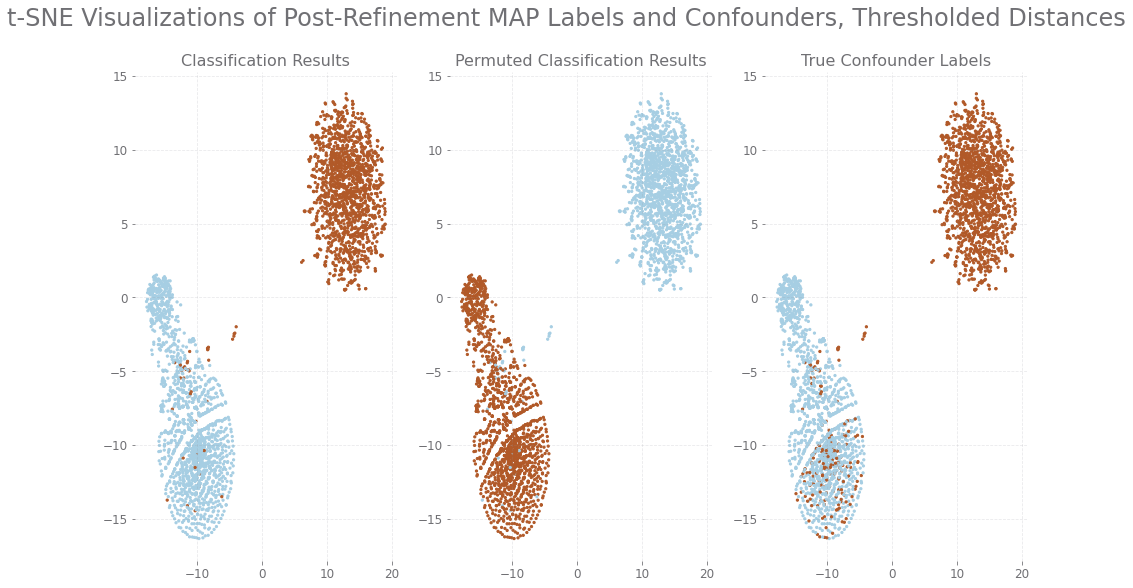

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((16,9)))
axes[0].scatter(tsne[:,0], tsne[:,1], c=refinemaplab[:sz], cmap='Paired', s=5)
axes[1].scatter(tsne[:,0], tsne[:,1], c=1-refinemaplab[:sz], cmap='Paired', s=5)
axes[2].scatter(tsne[:,0], tsne[:,1], c=labels[sz:2*sz], cmap='Paired', s=5)
axes[0].set_title('Classification Results', fontsize=16)
axes[1].set_title('Permuted Classification Results', fontsize=16)
axes[2].set_title('True Confounder Labels', fontsize=16)
fig.suptitle('t-SNE Visualizations of Post-Refinement MAP Labels and Confounders, Thresholded Distances', fontsize=24)